In [1]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch
import pytorch_forecasting as pf
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import psycopg2

import config
import utility_funcs as tsp

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

c:\Users\raphc\.conda\envs\eve_trading\lib\site-packages\pytorch_forecasting\models\base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
# Database credentials
db_credentials = {
    'dbname': config.dbname,
    'user': config.user,
    'password': config.password,
    'host': config.host,
    'port': config.port
}


In [187]:
def fill_missing_dates(df, date_col):
    """
    Fill missing dates in a DataFrame and forward-fill the data.

    Parameters:
    df (pd.DataFrame): The DataFrame to process.
    date_col (str): The name of the date column in the DataFrame.

    Returns:
    pd.DataFrame: A DataFrame with missing dates filled and data forward-filled.
    """
    # Ensure 'date' column is in datetime format
    df[date_col] = pd.to_datetime(df[date_col])

    # Create a complete date range
    start_date = df[date_col].min()
    end_date = df[date_col].max()
    date_range = pd.date_range(start=start_date, end=end_date)

    # Convert date range to DataFrame
    date_df = pd.DataFrame(date_range, columns=[date_col])

    # Merge the new date DataFrame with the original DataFrame
    df_complete = pd.merge(date_df, df, on=date_col, how='outer')

    # Forward fill the missing values
    df_complete.fillna(method='ffill', inplace=True)

    return df_complete




In [ ]:
# Example usage:
# Assuming price_df is your DataFrame and 'date' is the date column
# filled_df = fill_missing_dates(price_df, 'date')
# print(filled_df)

In [114]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine

def get_daily_destruction_history(ship_type_id, db_credentials):
    # SQL query
    query = """
    SELECT day, total_ships_destroyed
    FROM daily_ship_destructions
    WHERE ship_type_id = %s
    ORDER BY day;
    """

    # SQLAlchemy engine for Pandas
    engine = create_engine(f'postgresql+psycopg2://{db_credentials["user"]}:{db_credentials["password"]}@{db_credentials["host"]}:{db_credentials["port"]}/{db_credentials["dbname"]}')

    # Use Pandas to load the query results into a DataFrame
    try:
        df = pd.read_sql(query, engine, params=(ship_type_id,))
        # Convert 'date' column to datetime and sort by date
        # Adjust the conversion for timezone-aware datetime objects
        # df['date'] = pd.to_datetime(df['day']).dt.tz_localize(None).dt.date

        
        # df['day'] = pd.to_datetime(df['day']).dt.tz_convert(None).dt.date
        # df['date'] = pd.to_datetime(df['day']).dt.date
        df['date'] = pd.to_datetime(df['day'], utc=True).dt.date
        df = df.sort_values(by='date')
        df = df.drop('day', axis=1)
        
        
        # Step 1: Create a complete date range
        start_date = df['date'].min()  # start from the earliest date in your DataFrame
        end_date = df['date'].max()    # end at the latest date in your DataFrame
        date_range = pd.date_range(start=start_date, end=end_date)
        # print(date_range)

        # Step 2: Create a DataFrame from this date range
        date_df = pd.DataFrame(date_range, columns=['date'])
        date_df['date'] = pd.to_datetime(date_df['date'], utc=True).dt.date
        
        # # Step 3: Merge this new DataFrame with your BNI_destruction_df
        merged_df = pd.merge(date_df, df, on='date', how='left')
        # print(merged_df)
        # Step 4: Fill missing 'total_ships_destroyed' values with 0
        merged_df['total_ships_destroyed'].fillna(0, inplace=True)
        # Now merged_df will have an entry for each day with 'total_ships_destroyed' set to 0 where missing
        # print(merged_df.head())
        
        return merged_df

    except Exception as e:
        print(f"An error occurred: {e}")
        return None





    

In [28]:
def get_player_count_data(start_date, end_date, db_credentials):
    # SQL query to fetch data from player_count table within the date range
    query = """
    SELECT * FROM player_count
    WHERE date >= %s AND date <= %s;
    """

    # Create SQLAlchemy engine
    engine = create_engine(f'postgresql+psycopg2://{db_credentials["user"]}:{db_credentials["password"]}@{db_credentials["host"]}:{db_credentials["port"]}/{db_credentials["dbname"]}')

    # Fetch data into a DataFrame
    try:
        df = pd.read_sql(query, engine, params=(start_date, end_date))

        # Convert 'date' column to datetime if necessary and sort by date
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values(by='date')

        return df

    except Exception as e:
        print(f"An error occurred: {e}")
        return None


In [22]:
def get_market_history(type_id, region_id, db_credentials):
    # SQL query
    query = """
    SELECT * FROM market_history WHERE type_id = %s AND region_id = %s ;
    """

    # SQLAlchemy engine for Pandas
    engine = create_engine(f'postgresql+psycopg2://{db_credentials["user"]}:{db_credentials["password"]}@{db_credentials["host"]}:{db_credentials["port"]}/{db_credentials["dbname"]}')

    # Use Pandas to load the query results into a DataFrame
    try:
        df = pd.read_sql(query, engine, params=(type_id, region_id))
         # Convert 'date' column to datetime and sort by date
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values(by='date')
        return df

    except Exception as e:
        print(f"An error occurred: {e}")
        return None


In [163]:
BNI_price_df = get_market_history(33151, 10000002, db_credentials)

In [26]:
PLEX_price_df = get_market_history(44992, 10000002, db_credentials)

In [29]:
player_count_df = get_player_count_data('2020-01-01', '2020-12-31', db_credentials)

In [150]:
BNI_destruction_df = get_daily_destruction_history(33151, db_credentials)

           date  total_ships_destroyed
0    2020-01-01                   16.0
1    2020-01-02                    5.0
2    2020-01-03                   13.0
3    2020-01-04                   15.0
4    2020-01-05                    NaN
..          ...                    ...
361  2020-12-27                   11.0
362  2020-12-28                    NaN
363  2020-12-29                   11.0
364  2020-12-30                   12.0
365  2020-12-31                   10.0

[366 rows x 2 columns]
         date  total_ships_destroyed
0  2020-01-01                   16.0
1  2020-01-02                    5.0
2  2020-01-03                   13.0
3  2020-01-04                   15.0
4  2020-01-05                    0.0


In [156]:
import pandas as pd

# Assuming df_long and df_short are your DataFrames
# And they both have a 'date' column

# Convert the 'date' column to datetime if it's not already
# df_long['date'] = pd.to_datetime(df_long['date'])
# BNI_destruction_df['date'] = pd.to_datetime(df_sBNI_destruction_dfhort['date'])

# Set 'date' as the index
test_dest = BNI_destruction_df.set_index('date', inplace=False)
test_price = BNI_price_df.set_index('date', inplace=False)

# Find dates that are in df_long but not in df_short
missing_dates = test_dest.index.difference(test_price.index)

print("Dates present in df_long but missing in df_short:")
print(missing_dates)


Dates present in df_long but missing in df_short:
Index([2020-01-10, 2020-01-17, 2020-02-09, 2020-02-22, 2020-02-25, 2020-03-01,
       2020-03-03, 2020-03-11, 2020-03-30, 2020-04-16, 2020-05-06, 2020-05-07,
       2020-05-25, 2020-05-26, 2020-06-12, 2020-06-13, 2020-07-21, 2020-07-25,
       2020-07-31, 2020-08-08, 2020-08-10, 2020-08-15, 2020-08-29, 2020-09-04,
       2020-09-15, 2020-10-14, 2020-10-18, 2020-10-19, 2020-10-22, 2020-10-23,
       2020-10-24, 2020-11-13, 2020-11-16, 2020-11-24, 2020-12-14, 2020-12-21,
       2020-12-28],
      dtype='object', name='date')


In [ ]:
# TODO
# interpolate missing values for price history. Maybe just use last available data and fill?

In [189]:
# Example usage:
# Assuming price_df is your DataFrame and 'date' is the date column
BNI_price_df_filled = fill_missing_dates(BNI_price_df, 'date')
print(BNI_price_df_filled)

          date   region_id  type_id      average      highest       lowest  \
0   2020-01-01  10000002.0  33151.0  139025787.0  154999993.0  109252864.0   
1   2020-01-02  10000002.0  33151.0  148913761.0  154999994.0  109353250.0   
2   2020-01-03  10000002.0  33151.0  135639118.0  154998998.0  129000000.0   
3   2020-01-04  10000002.0  33151.0  147348145.0  154888886.0  138335000.0   
4   2020-01-05  10000002.0  33151.0  147091370.0  154999999.0  112128562.0   
..         ...         ...      ...          ...          ...          ...   
361 2020-12-27  10000002.0  33151.0  188003846.0  194700000.0  175100000.0   
362 2020-12-28  10000002.0  33151.0  188003846.0  194700000.0  175100000.0   
363 2020-12-29  10000002.0  33151.0  183433333.0  194950000.0  175300000.0   
364 2020-12-30  10000002.0  33151.0  188725000.0  193400000.0  175400000.0   
365 2020-12-31  10000002.0  33151.0  183246154.0  193200000.0  172800000.0   

     volume  order_count  
0      32.0         22.0  
1      15

In [177]:

price_df = BNI_price_df.copy()
# Create a complete date range
start_date = price_df['date'].min()
end_date = price_df['date'].max()
date_range = pd.date_range(start=start_date, end=end_date)

# Convert date range to DataFrame
date_df = pd.DataFrame(date_range, columns=['date'])

# Merge the new date DataFrame with the original DataFrame
# Perform an outer join to ensure all dates are included
price_df_complete = pd.merge(date_df, price_df, on='date', how='outer')

# Forward fill the missing values
price_df_complete.fillna(method='ffill', inplace=True)

print(price_df_complete)

          date   region_id  type_id      average      highest       lowest  \
0   2020-01-01  10000002.0  33151.0  139025787.0  154999993.0  109252864.0   
1   2020-01-02  10000002.0  33151.0  148913761.0  154999994.0  109353250.0   
2   2020-01-03  10000002.0  33151.0  135639118.0  154998998.0  129000000.0   
3   2020-01-04  10000002.0  33151.0  147348145.0  154888886.0  138335000.0   
4   2020-01-05  10000002.0  33151.0  147091370.0  154999999.0  112128562.0   
..         ...         ...      ...          ...          ...          ...   
361 2020-12-27  10000002.0  33151.0  188003846.0  194700000.0  175100000.0   
362 2020-12-28  10000002.0  33151.0  188003846.0  194700000.0  175100000.0   
363 2020-12-29  10000002.0  33151.0  183433333.0  194950000.0  175300000.0   
364 2020-12-30  10000002.0  33151.0  188725000.0  193400000.0  175400000.0   
365 2020-12-31  10000002.0  33151.0  183246154.0  193200000.0  172800000.0   

     volume  order_count  
0      32.0         22.0  
1      15

In [181]:
print(price_df_complete[price_df_complete['date']=='2020-01-11'])

         date   region_id  type_id      average      highest       lowest  \
10 2020-01-11  10000002.0  33151.0  122225250.0  131244998.0  112200183.0   

    volume  order_count  
10    43.0         28.0  


In [172]:
print(price_df_complete[price_df_complete.index=='2020-01-10'])

            region_id  type_id    average    highest     lowest  volume  \
2020-01-10   10000002    33151  133894884  144999999  126250003      17   

            order_count  
2020-01-10           16  


In [182]:


# Assuming BNI_price_df, player_count_df, and BNI_destruction_df are your DataFrames
# Convert 'date' columns in all DataFrames to datetime64[ns]
price_df_complete['date'] = pd.to_datetime(price_df_complete['date'])
player_count_df['date'] = pd.to_datetime(player_count_df['date'])
BNI_destruction_df['date'] = pd.to_datetime(BNI_destruction_df['date'])






In [ ]:
print()

In [183]:
BNI_price_df = BNI_price_df.sort_values(by='date')
player_count_df = player_count_df.sort_values(by='date')
BNI_destruction_df = BNI_destruction_df.sort_values(by='date')
PLEX_price_df = PLEX_price_df.sort_values(by='date')


In [184]:
PLEX_price_df

,date,region_id,type_id,average,highest,lowest,volume,order_count
1,2020-01-01,10000002,44992,3210100,3304980,3201000,1377962,2588
293,2020-01-02,10000002,44992,3186222,3281720,3175104,1356177,2662
294,2020-01-03,10000002,44992,3200012,3290000,3195601,1375414,2419
295,2020-01-04,10000002,44992,3199306,3291980,3180000,1504226,2634
296,2020-01-05,10000002,44992,3192202,3304000,3181390,1352393,2425
...,...,...,...,...,...,...,...,...
23,2020-12-26,10000002,44992,2770000,2800000,2694000,1885760,3762
24,2020-12-27,10000002,44992,2657000,2757000,2644000,1289921,2668
25,2020-12-29,10000002,44992,2647000,2765000,2638000,1274018,2537
26,2020-12-30,10000002,44992,2643000,2757000,2636000,1217182,2477


In [185]:
# Merging the DataFrames on the 'date' column

combined_df = pd.merge(price_df_complete, player_count_df, on='date', how='outer')
combined_df = pd.merge(combined_df, BNI_destruction_df, on='date', how='outer')

# Now 'combined_df' will have a unified 'date' column

# TODO add PLEX data to the df

In [186]:
combined_df

,date,region_id,type_id,average,highest,lowest,volume,order_count,player_count,total_ships_destroyed
0,2020-01-01,10000002.0,33151.0,139025787.0,154999993.0,109252864.0,32.0,22.0,23373,16.0
1,2020-01-02,10000002.0,33151.0,148913761.0,154999994.0,109353250.0,15.0,14.0,22787,5.0
2,2020-01-03,10000002.0,33151.0,135639118.0,154998998.0,129000000.0,29.0,23.0,23005,13.0
3,2020-01-04,10000002.0,33151.0,147348145.0,154888886.0,138335000.0,44.0,36.0,25857,15.0
4,2020-01-05,10000002.0,33151.0,147091370.0,154999999.0,112128562.0,29.0,28.0,26637,0.0
...,...,...,...,...,...,...,...,...,...,...
361,2020-12-27,10000002.0,33151.0,188003846.0,194700000.0,175100000.0,26.0,25.0,24544,11.0
362,2020-12-28,10000002.0,33151.0,188003846.0,194700000.0,175100000.0,26.0,25.0,22616,0.0
363,2020-12-29,10000002.0,33151.0,183433333.0,194950000.0,175300000.0,15.0,14.0,23188,11.0
364,2020-12-30,10000002.0,33151.0,188725000.0,193400000.0,175400000.0,20.0,20.0,23457,12.0


In [190]:
data = combined_df

In [191]:
data["time_idx"] = (data["date"] - data["date"].min()).dt.days

In [192]:
data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings


In [215]:
data['day_of_week'] = data['date'].dt.dayofweek.astype(str).astype("category")

In [216]:
data.head()

,date,region_id,type_id,average,highest,lowest,volume,order_count,player_count,total_ships_destroyed,...,player_count_ZScore_7_day_ma,total_ships_destroyed_ZScore_7_day_ma,average_ZScore_20_day_ma,highest_ZScore_20_day_ma,lowest_ZScore_20_day_ma,volume_ZScore_20_day_ma,order_count_ZScore_20_day_ma,player_count_ZScore_20_day_ma,total_ships_destroyed_ZScore_20_day_ma,day_of_week
7,2020-01-08,10000002.0,33151.0,138074409.0,140000000.0,125005005.0,15.0,14.0,20995.0,5.0,...,-0.930391,-0.707107,-0.750255,-2.137610,0.137735,-0.890724,-0.751253,-0.930391,-0.707107,2
8,2020-01-09,10000002.0,33151.0,133894884.0,144999999.0,126250003.0,17.0,16.0,20517.0,9.0,...,-1.059214,-0.132453,-1.288572,-1.069691,0.243459,-0.654998,-0.489494,-1.059214,-0.132453,3
9,2020-01-10,10000002.0,33151.0,133894884.0,144999999.0,126250003.0,17.0,16.0,20976.0,15.0,...,-0.428550,0.816497,-1.129118,-0.949822,0.229107,-0.593572,-0.445085,-0.428550,0.816497,4
10,2020-01-11,10000002.0,33151.0,122225250.0,131244998.0,112200183.0,43.0,28.0,25577.0,16.0,...,1.921263,0.834058,-2.136923,-2.115249,-1.188781,1.270843,0.876070,1.921263,0.834058,5
11,2020-01-12,10000002.0,33151.0,119339726.0,128799997.0,112200000.0,44.0,27.0,25439.0,14.0,...,1.377717,0.381691,-1.921562,-1.834945,-1.054116,1.154553,0.684303,1.377717,0.381691,6


In [194]:

data['type_id'] = data['type_id'].astype('category')
data['region_id'] = data['region_id'].astype('category')
data['month'] = data['month'].astype('category')

data['average'] = data['average'].astype(float)
data['highest'] = data['highest'].astype(float)
data['lowest'] = data['lowest'].astype(float)
data['volume'] = data['volume'].astype(float)
data['order_count'] = data['order_count'].astype(float)

data['player_count'] = data['player_count'].astype(float)
data['total_ships_destroyed'] = data['total_ships_destroyed'].astype(float)




data.head()
# validation = data[data['date'] >= "2022-01-01"]


,date,region_id,type_id,average,highest,lowest,volume,order_count,player_count,total_ships_destroyed,time_idx,month
0,2020-01-01,10000002.0,33151.0,139025787.0,154999993.0,109252864.0,32.0,22.0,23373.0,16.0,0,1
1,2020-01-02,10000002.0,33151.0,148913761.0,154999994.0,109353250.0,15.0,14.0,22787.0,5.0,1,1
2,2020-01-03,10000002.0,33151.0,135639118.0,154998998.0,129000000.0,29.0,23.0,23005.0,13.0,2,1
3,2020-01-04,10000002.0,33151.0,147348145.0,154888886.0,138335000.0,44.0,36.0,25857.0,15.0,3,1
4,2020-01-05,10000002.0,33151.0,147091370.0,154999999.0,112128562.0,29.0,28.0,26637.0,0.0,4,1


In [195]:
columns = ["average", "highest", "lowest", "volume", "order_count", 'player_count', 'total_ships_destroyed']

data = tsp.z_score_normalize(data, columns)


data.head()

,date,region_id,type_id,average,highest,lowest,volume,order_count,player_count,total_ships_destroyed,time_idx,month,average_ZScore,highest_ZScore,lowest_ZScore,volume_ZScore,order_count_ZScore,player_count_ZScore,total_ships_destroyed_ZScore
7,2020-01-08,10000002.0,33151.0,138074409.0,140000000.0,125005005.0,15.0,14.0,20995.0,5.0,7,1,-0.750255,-2.137610,0.137735,-0.890724,-0.751253,-0.930391,-0.707107
8,2020-01-09,10000002.0,33151.0,133894884.0,144999999.0,126250003.0,17.0,16.0,20517.0,9.0,8,1,-1.288572,-1.069691,0.243459,-0.654998,-0.489494,-1.059214,-0.132453
9,2020-01-10,10000002.0,33151.0,133894884.0,144999999.0,126250003.0,17.0,16.0,20976.0,15.0,9,1,-1.129118,-0.949822,0.229107,-0.593572,-0.445085,-0.428550,0.816497
10,2020-01-11,10000002.0,33151.0,122225250.0,131244998.0,112200183.0,43.0,28.0,25577.0,16.0,10,1,-2.136923,-2.115249,-1.188781,1.270843,0.876070,1.921263,0.834058
11,2020-01-12,10000002.0,33151.0,119339726.0,128799997.0,112200000.0,44.0,27.0,25439.0,14.0,11,1,-1.921562,-1.834945,-1.054116,1.154553,0.684303,1.377717,0.381691


In [196]:
zscore_cols = ['average_ZScore', 'highest_ZScore', 'lowest_ZScore', 'volume_ZScore', 'order_count_ZScore', 'player_count_ZScore', 'total_ships_destroyed_ZScore']


data = tsp.moving_avg(data, zscore_cols, window=2)
# data = tsp.moving_avg(data, zscore_cols, window=5)
data = tsp.moving_avg(data, zscore_cols, window=7)
data = tsp.moving_avg(data, zscore_cols, window=20)

In [22]:
data = tsp.moving_avg(data, columns, 7)

In [23]:
data = tsp.moving_avg(data, columns, 2)

In [197]:
data.dtypes


date                                      datetime64[ns]
region_id                                       category
type_id                                         category
average                                          float64
highest                                          float64
lowest                                           float64
volume                                           float64
order_count                                      float64
player_count                                     float64
total_ships_destroyed                            float64
time_idx                                           int64
month                                           category
average_ZScore                                   float64
highest_ZScore                                   float64
lowest_ZScore                                    float64
volume_ZScore                                    float64
order_count_ZScore                               float64
player_count_ZScore            

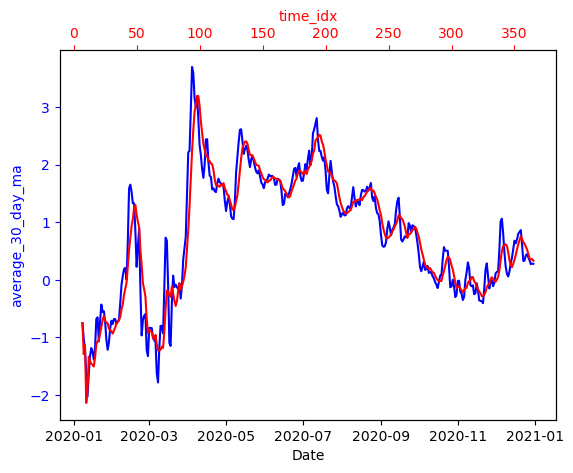

In [198]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

    
# Plot 'average_10_day_ma' over 'date'
ax1.plot(data['date'], data['average_ZScore_2_day_ma'], color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('average_30_day_ma', color='blue')
ax1.tick_params('y', colors='blue')

# Create a second x-axis for 'time_idx'
ax2 = ax1.twiny()
ax2.plot(data['time_idx'], data['average_ZScore_7_day_ma'], color='red')
ax2.set_xlabel('time_idx', color='red')
ax2.tick_params('x', colors='red')

plt.show()

In [26]:
print(data["time_idx"].max())

1821


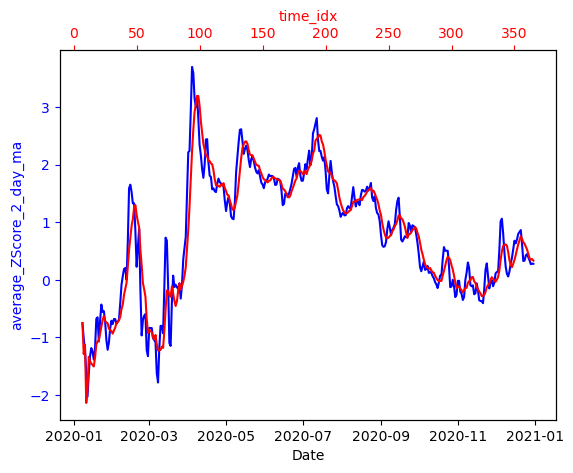

In [201]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

    
# Plot 'average_10_day_ma' over 'date'
ax1.plot(data['date'], data['average_ZScore_2_day_ma'], color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('average_ZScore_2_day_ma', color='blue')
ax1.tick_params('y', colors='blue')

# Create a second x-axis for 'time_idx'
ax2 = ax1.twiny()
ax2.plot(data['time_idx'], data['average_ZScore_7_day_ma'], color='red')
ax2.set_xlabel('time_idx', color='red')
ax2.tick_params('x', colors='red')

plt.show()

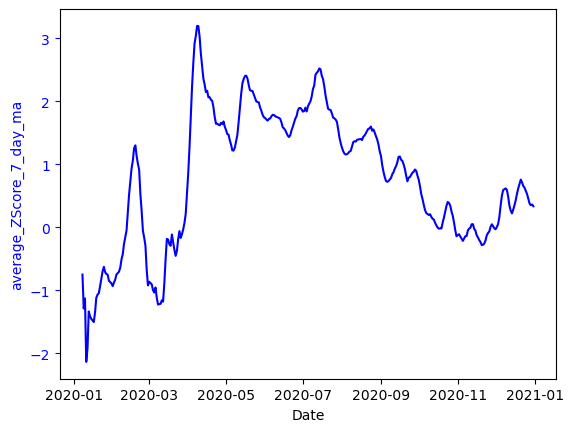

In [203]:
tsp.plot_ma(data, 'average_ZScore_7_day_ma', 'blue')

In [209]:
data = data[data['time_idx'] <= 300]

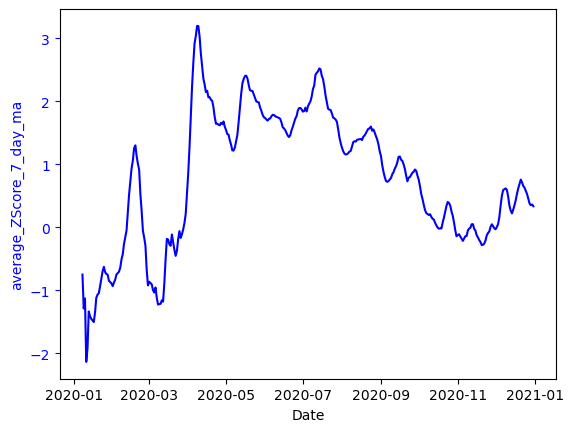

In [206]:
tsp.plot_ma(data, 'average_ZScore_7_day_ma', 'blue')

In [210]:
max_prediction_length = 10
max_encoder_length = 21
training_cutoff = data["time_idx"].max() - max_prediction_length

assert data['time_idx'].max() > training_cutoff, "training_cutoff is too high"
assert data['time_idx'].nunique() > max_encoder_length, "max_encoder_length is too high"
assert data['time_idx'].nunique() > max_prediction_length, "max_prediction_length is too high"


In [211]:
print(data['time_idx'].max())

300


In [213]:
print(data.head())

         date   region_id  type_id      average      highest       lowest  \
7  2020-01-08  10000002.0  33151.0  138074409.0  140000000.0  125005005.0   
8  2020-01-09  10000002.0  33151.0  133894884.0  144999999.0  126250003.0   
9  2020-01-10  10000002.0  33151.0  133894884.0  144999999.0  126250003.0   
10 2020-01-11  10000002.0  33151.0  122225250.0  131244998.0  112200183.0   
11 2020-01-12  10000002.0  33151.0  119339726.0  128799997.0  112200000.0   

    volume  order_count  player_count  total_ships_destroyed  ...  \
7     15.0         14.0       20995.0                    5.0  ...   
8     17.0         16.0       20517.0                    9.0  ...   
9     17.0         16.0       20976.0                   15.0  ...   
10    43.0         28.0       25577.0                   16.0  ...   
11    44.0         27.0       25439.0                   14.0  ...   

    order_count_ZScore_7_day_ma player_count_ZScore_7_day_ma  \
7                     -0.751253                    -0.9303

In [212]:
print(data.columns)

Index(['date', 'region_id', 'type_id', 'average', 'highest', 'lowest',
       'volume', 'order_count', 'player_count', 'total_ships_destroyed',
       'time_idx', 'month', 'average_ZScore', 'highest_ZScore',
       'lowest_ZScore', 'volume_ZScore', 'order_count_ZScore',
       'player_count_ZScore', 'total_ships_destroyed_ZScore',
       'average_ZScore_2_day_ma', 'highest_ZScore_2_day_ma',
       'lowest_ZScore_2_day_ma', 'volume_ZScore_2_day_ma',
       'order_count_ZScore_2_day_ma', 'player_count_ZScore_2_day_ma',
       'total_ships_destroyed_ZScore_2_day_ma', 'average_ZScore_7_day_ma',
       'highest_ZScore_7_day_ma', 'lowest_ZScore_7_day_ma',
       'volume_ZScore_7_day_ma', 'order_count_ZScore_7_day_ma',
       'player_count_ZScore_7_day_ma', 'total_ships_destroyed_ZScore_7_day_ma',
       'average_ZScore_20_day_ma', 'highest_ZScore_20_day_ma',
       'lowest_ZScore_20_day_ma', 'volume_ZScore_20_day_ma',
       'order_count_ZScore_20_day_ma', 'player_count_ZScore_20_day_ma',
  

In [217]:


training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="average_ZScore_7_day_ma",
    group_ids=["type_id"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_categoricals=["month", "day_of_week"],
    time_varying_known_reals=["time_idx", 'player_count'],
    time_varying_unknown_reals=[
        # 'average_ZScore', 'highest_ZScore', 'lowest_ZScore', 'volume_ZScore',
    #    'order_count_ZScore', 
       'average_ZScore_2_day_ma',
       'highest_ZScore_2_day_ma', 'lowest_ZScore_2_day_ma',
       'volume_ZScore_2_day_ma', 'order_count_ZScore_2_day_ma',
       'average_ZScore_7_day_ma', 'highest_ZScore_7_day_ma',
       'lowest_ZScore_7_day_ma', 'volume_ZScore_7_day_ma',
       'order_count_ZScore_7_day_ma', 'average_ZScore_20_day_ma',
       'highest_ZScore_20_day_ma', 'lowest_ZScore_20_day_ma',
       'volume_ZScore_20_day_ma', 'order_count_ZScore_20_day_ma',
       'player_count_ZScore_2_day_ma', 'player_count_ZScore_7_day_ma',
       'total_ships_destroyed_ZScore_2_day_ma', 'total_ships_destroyed_ZScore_7_day_ma', 'total_ships_destroyed_ZScore_20_day_ma'
       
        
    ],

    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series

# testing = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 32  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [235]:
print(len(validation))

1


In [218]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


tensor(0.2386, device='cuda:0')

In [219]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="gpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.00003,
    hidden_size=30,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=2,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    optimizer="Ranger",
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 80.6k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Finding best initial lr: 100%|██████████| 100/100 [00:25<00:00,  3.99it/s]
Learning rate set to 0.048977881936844644
Restoring states from the checkpoint path at c:\Users\raphc\OneDrive\Personal Projects\EVE Online Quant\EVE Markets\EVE code\forecasting\.lr_find_4bc332c6-d835-475f-b422-f500c298e3ce.ckpt
Restored all states from the checkpoint at c:\Users\raphc\OneDrive\Personal Projects\EVE Online Quant\EVE Markets\EVE code\forecasting\.lr_find_4bc332c6-d835-475f-b422-f500c298e3ce.ckpt


suggested learning rate: 0.048977881936844644


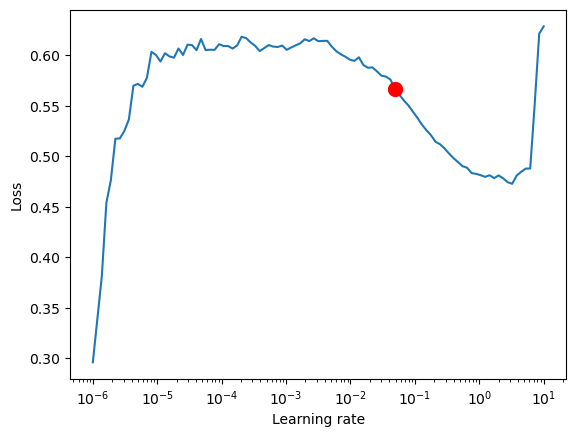

In [220]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [233]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=500,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.00001,
    hidden_size=32,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=16,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
    output_size=7)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 120.0k


In [234]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 95    
3  | prescalers                         | ModuleDict                      | 832   
4  | static_variable_selection          | VariableSelectionNetwork        | 5.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 54.5 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 6.2 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K 
9  | static_context_initial_cell_lstm 

Epoch 420: 100%|██████████| 9/9 [00:03<00:00,  2.94it/s, v_num=28, train_loss_step=0.304, val_loss=0.0753, train_loss_epoch=0.369]


In [236]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [237]:
# calcualte mean absolute error on validation set
predictions = best_tft.predict(val_dataloader, return_x=True, return_y=True, trainer_kwargs=dict(accelerator="gpu"))
MAE()(predictions.output, predictions.y)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


tensor(0.1242, device='cuda:0')

In [247]:
predictions.output

tensor([[0.2426, 0.2416, 0.2149, 0.2329, 0.2694, 0.2323, 0.2389, 0.2702, 0.2662,
         0.2354]], device='cuda:0')

In [238]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [244]:
print(raw_predictions)

Prediction(output=Output(prediction=tensor([[[-0.3666,  0.0415, -0.0224,  0.2426,  0.1968,  0.4154,  0.8310],
         [-0.3553,  0.0312, -0.0270,  0.2416,  0.2817,  0.4720,  0.8430],
         [-0.3298, -0.0111,  0.0042,  0.2149,  0.2992,  0.5113,  0.8156],
         [-0.3299, -0.0238,  0.0111,  0.2329,  0.2631,  0.5074,  0.8224],
         [-0.3553,  0.0626, -0.0502,  0.2694,  0.2671,  0.4688,  0.8494],
         [-0.3603,  0.0644, -0.0449,  0.2323,  0.2149,  0.4328,  0.8072],
         [-0.3463, -0.0175, -0.0057,  0.2389,  0.2368,  0.4836,  0.8042],
         [-0.3827,  0.0273, -0.0421,  0.2702,  0.2078,  0.4173,  0.8075],
         [-0.3711,  0.0267, -0.0305,  0.2662,  0.2832,  0.4787,  0.8244],
         [-0.3494, -0.0128,  0.0042,  0.2354,  0.3044,  0.5167,  0.8008]]],
       device='cuda:0'), encoder_attention=tensor([[[[0.1237, 0.0130, 0.0093, 0.0090, 0.0130, 0.0126, 0.0627, 0.1083,
           0.0281, 0.0444, 0.0336, 0.0156, 0.0201, 0.0834, 0.1513, 0.0374,
           0.0200, 0.0264, 0.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'encoder_length': <Figure size 1000x500 with 2 Axes>,
 'average_ZScore_7_day_ma_center': <Figure size 1000x500 with 2 Axes>,
 'average_ZScore_7_day_ma_scale': <Figure size 1000x500 with 2 Axes>,
 'time_idx': <Figure size 1000x500 with 2 Axes>,
 'player_count': <Figure size 1000x500 with 2 Axes>,
 'relative_time_idx': <Figure size 1000x500 with 2 Axes>,
 'average_ZScore_2_day_ma': <Figure size 1000x500 with 2 Axes>,
 'highest_ZScore_2_day_ma': <Figure size 1000x500 with 2 Axes>,
 'lowest_ZScore_2_day_ma': <Figure size 1000x500 with 2 Axes>,
 'volume_ZScore_2_day_ma': <Figure size 1000x500 with 2 Axes>,
 'order_count_ZScore_2_day_ma': <Figure size 1000x500 with 2 Axes>,
 'average_ZScore_7_day_ma': <Figure size 1000x500 with 2 Axes>,
 'highest_ZScore_7_day_ma': <Figure size 1000x500 with 2 Axes>,
 'lowest_ZScore_7_day_ma': <Figure size 1000x500 with 2 Axes>,
 'volume_ZScore_7_day_ma': <Figure size 1000x500 with 2 Axes>,
 'order_count_ZScore_7_day_ma': <Figure size 1000x500 with 2 Axes>,


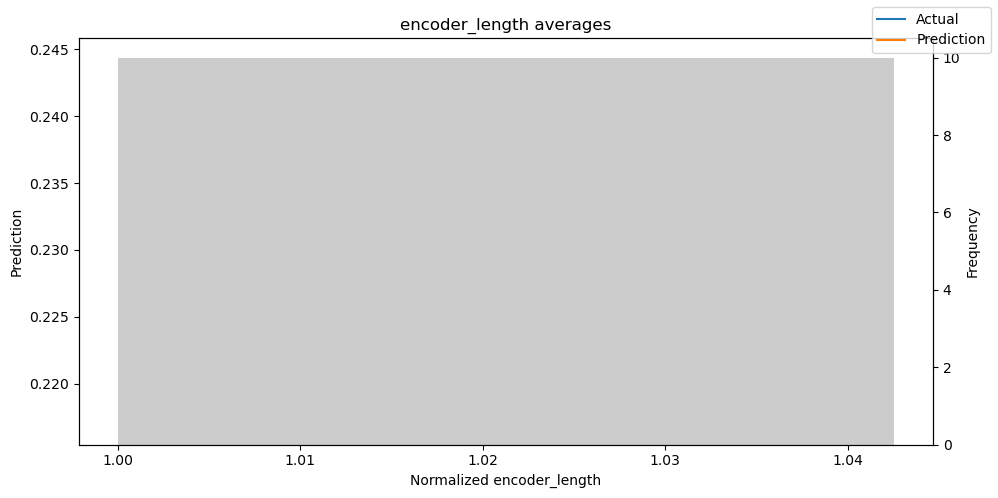

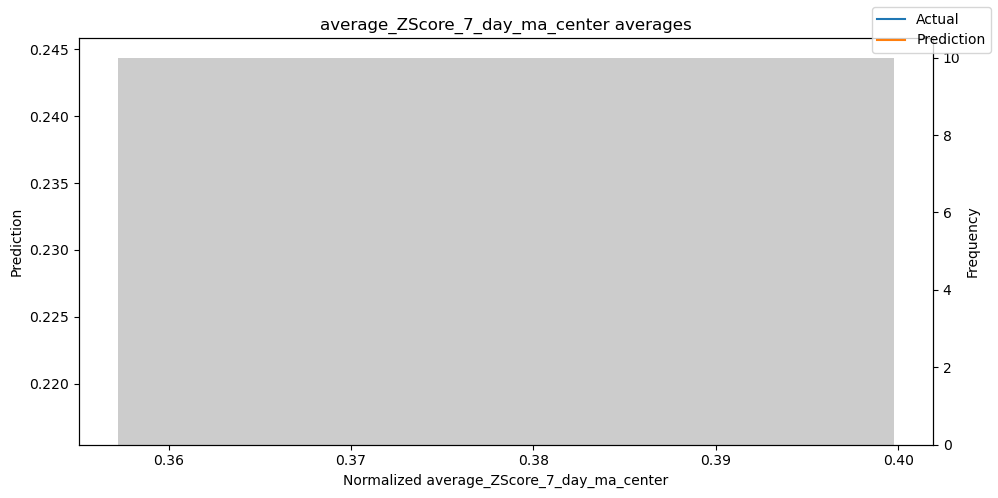

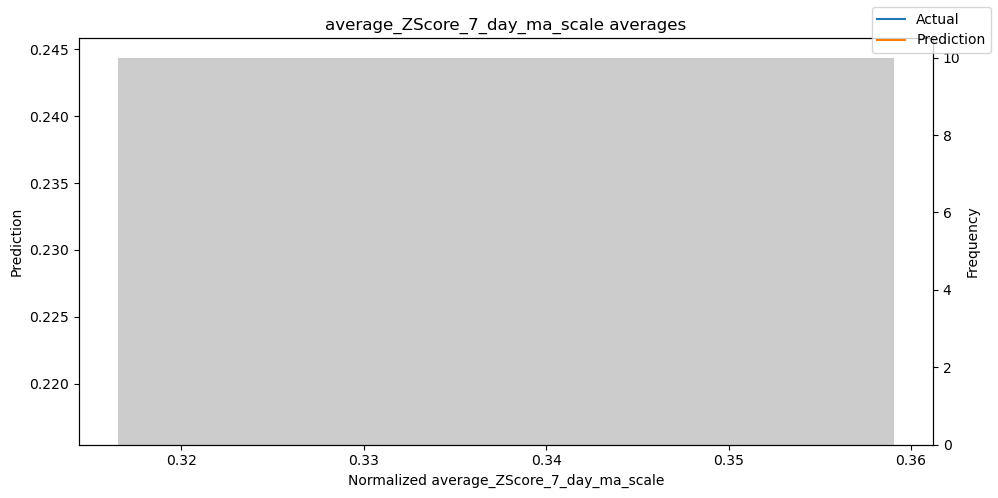

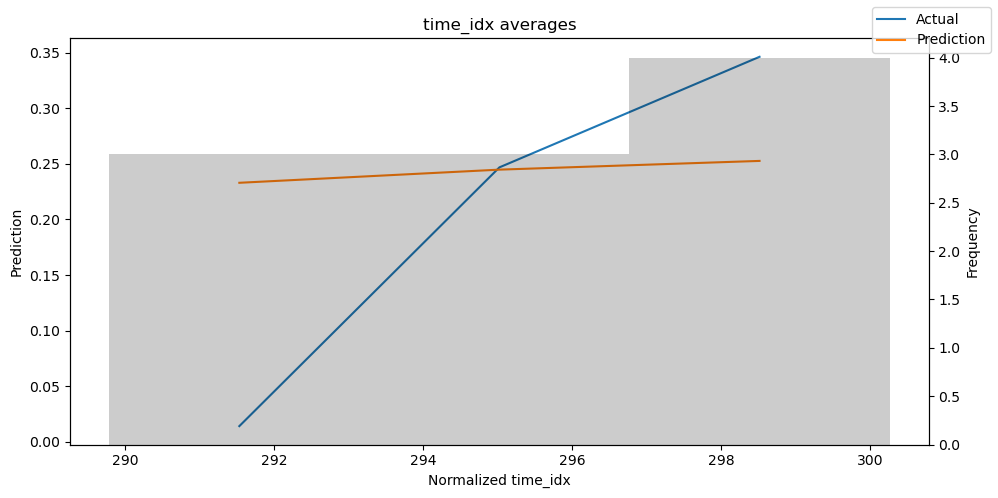

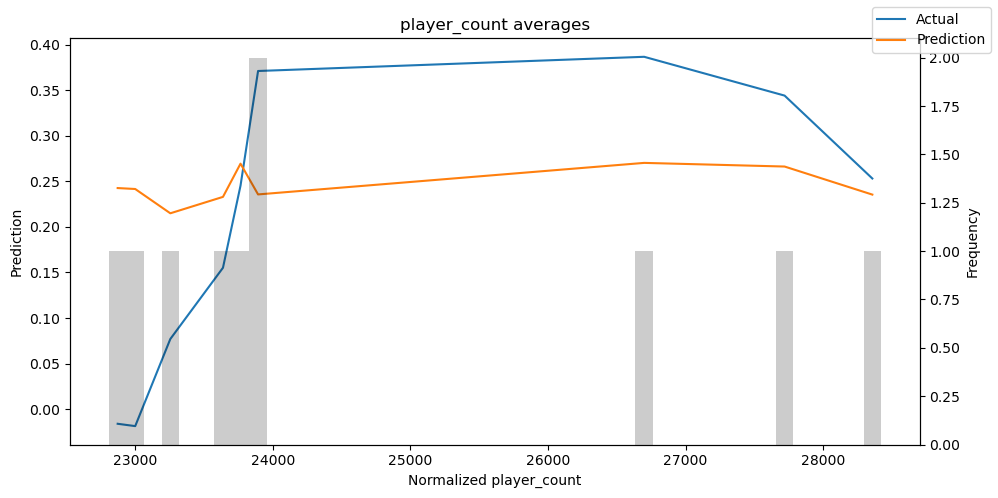

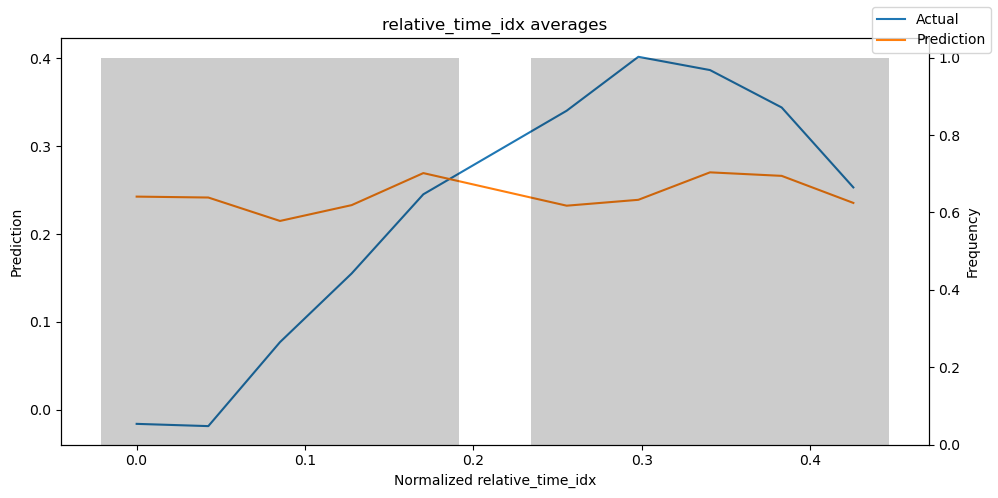

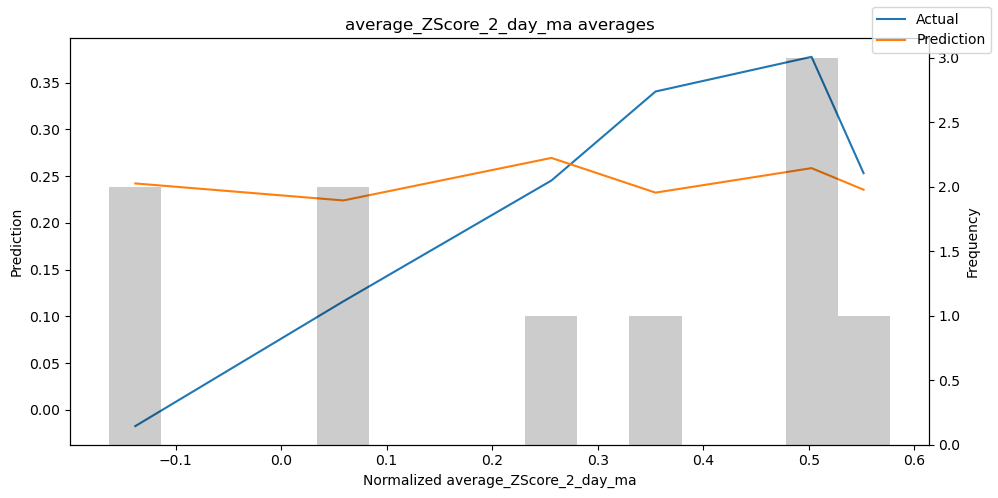

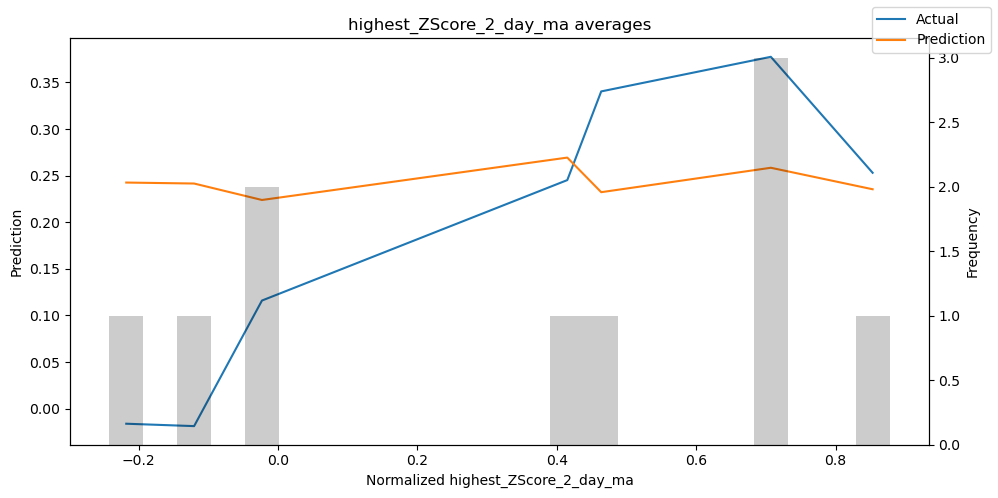

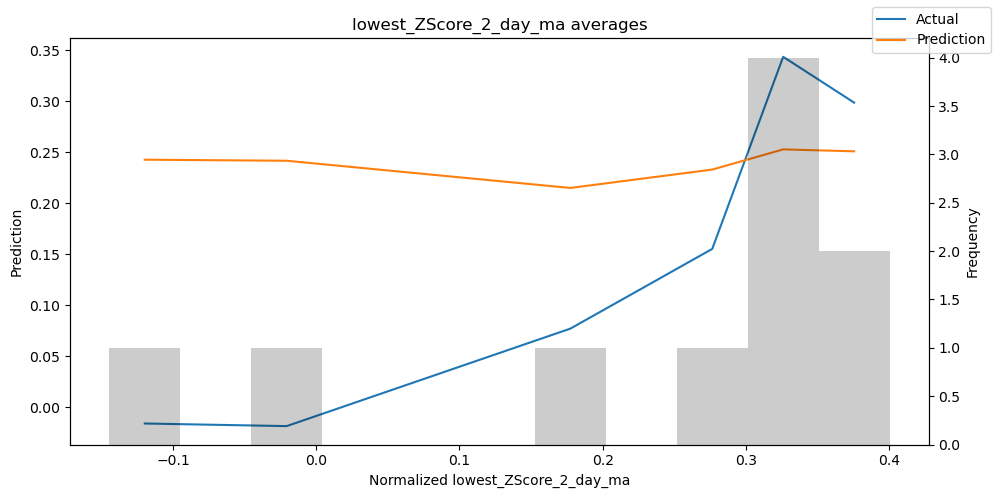

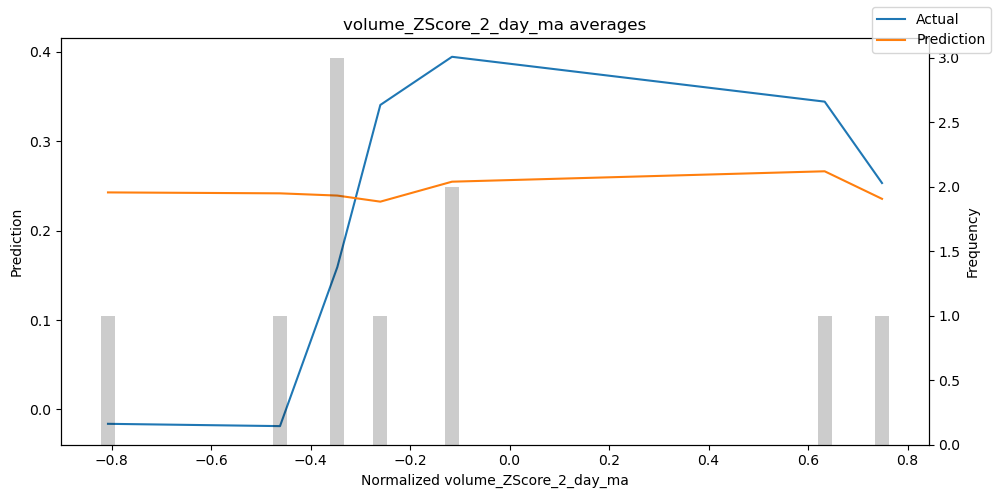

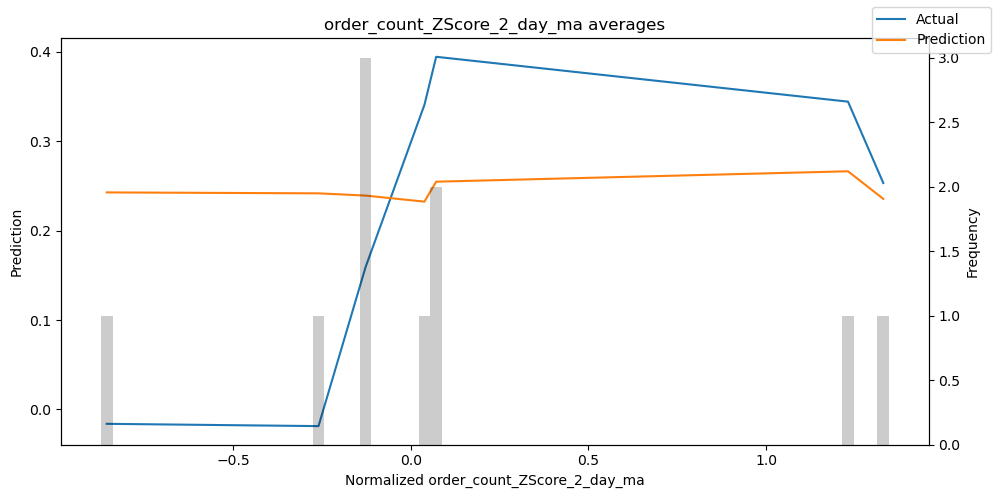

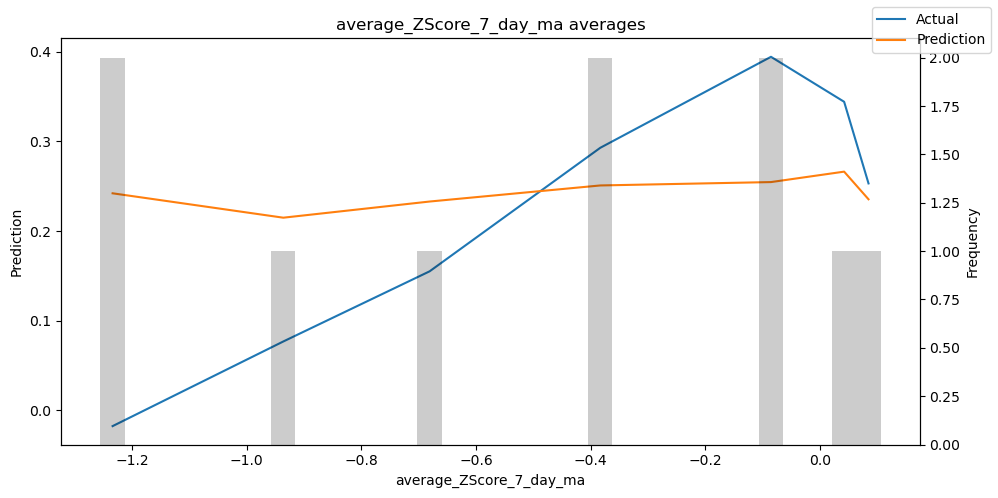

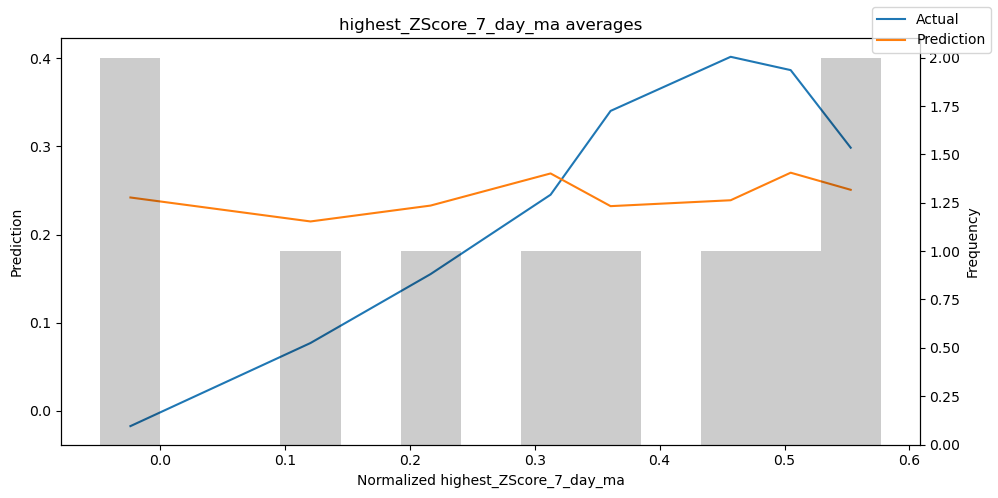

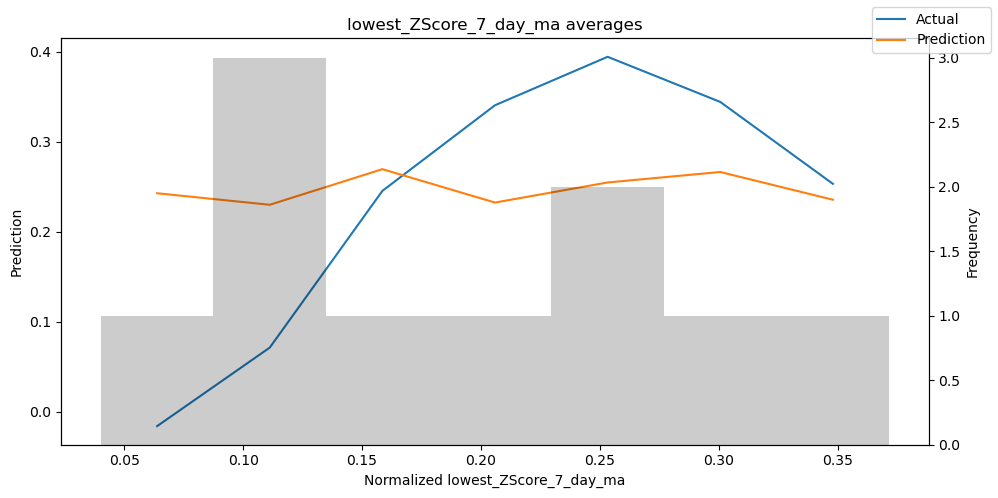

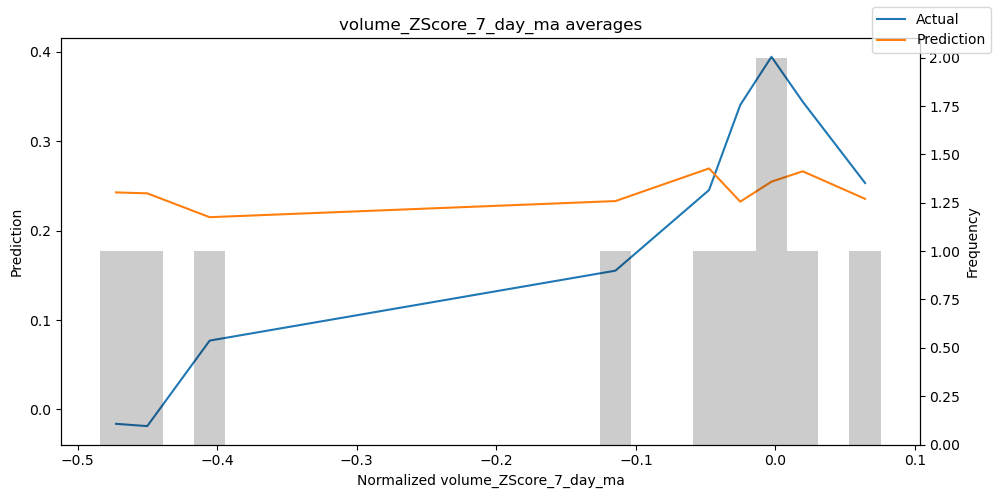

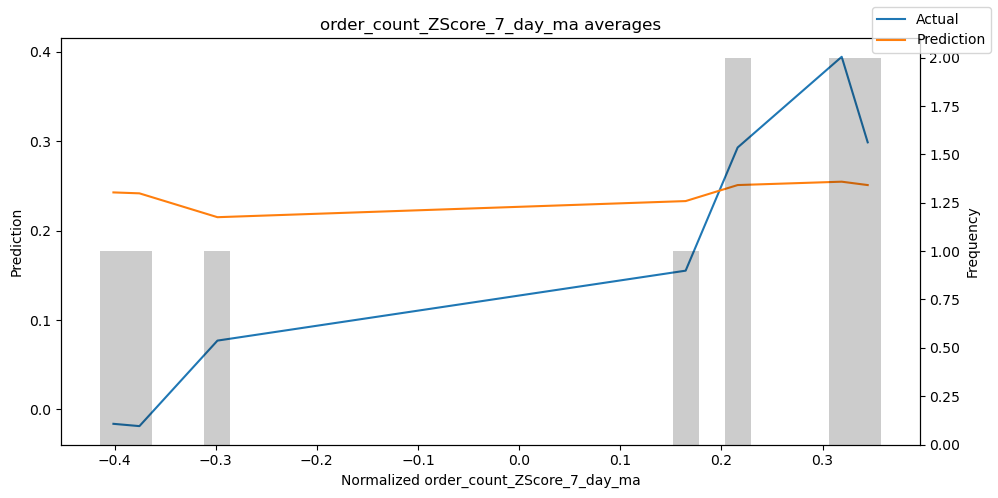

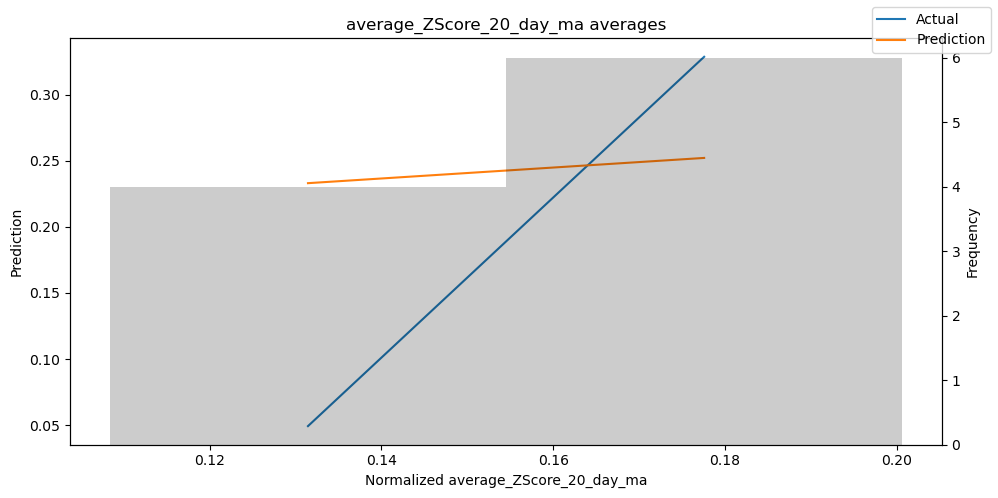

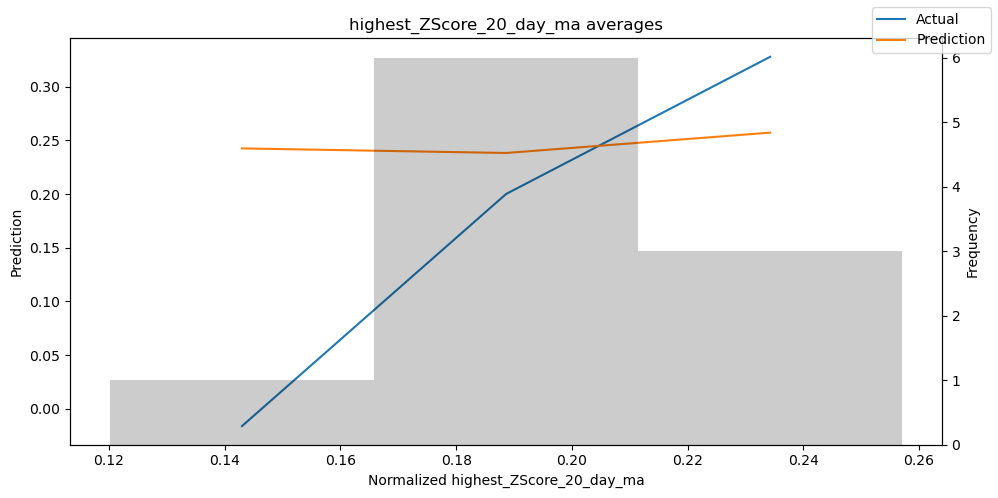

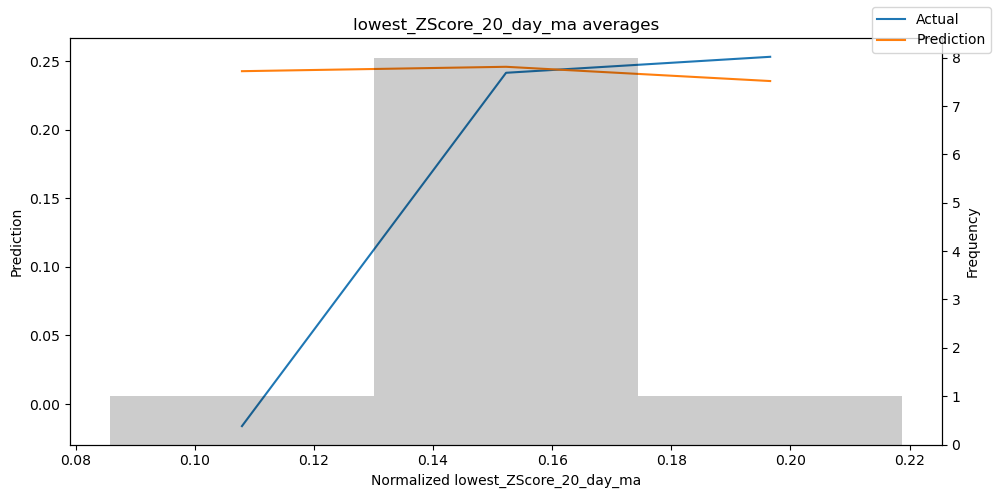

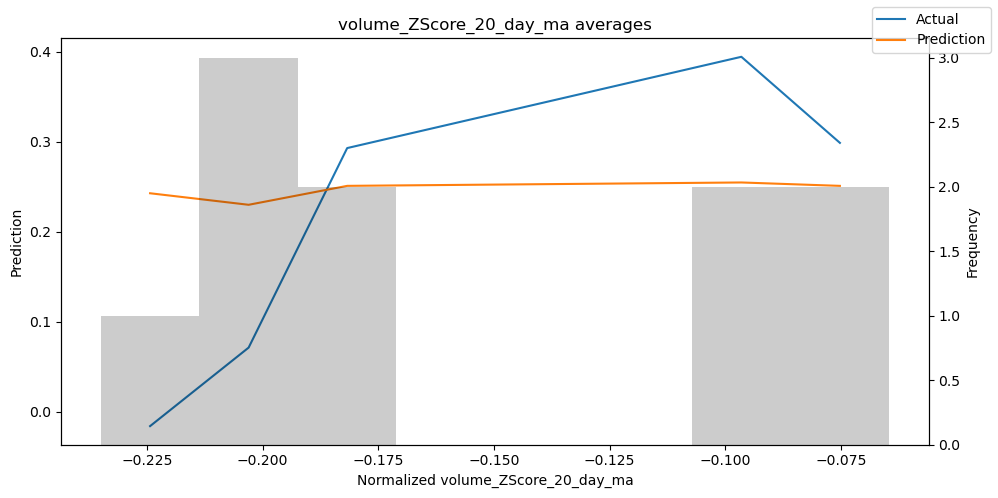

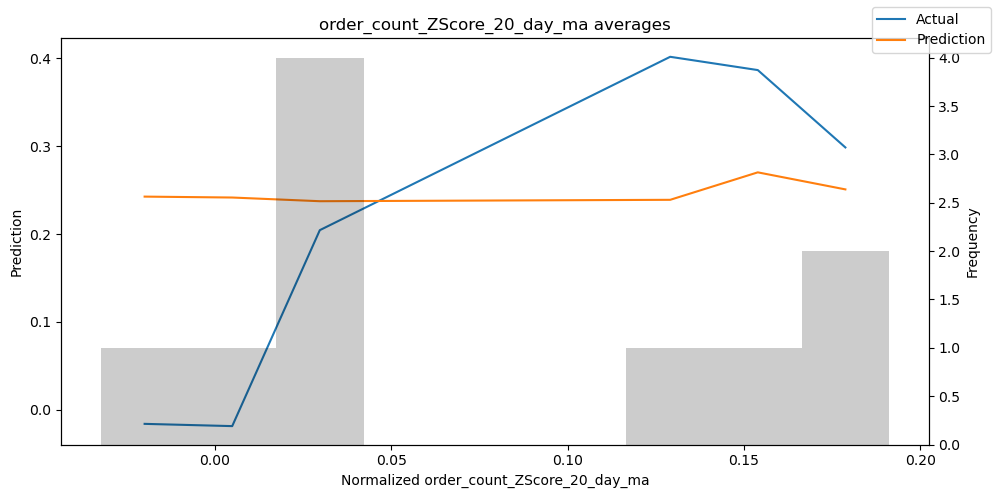

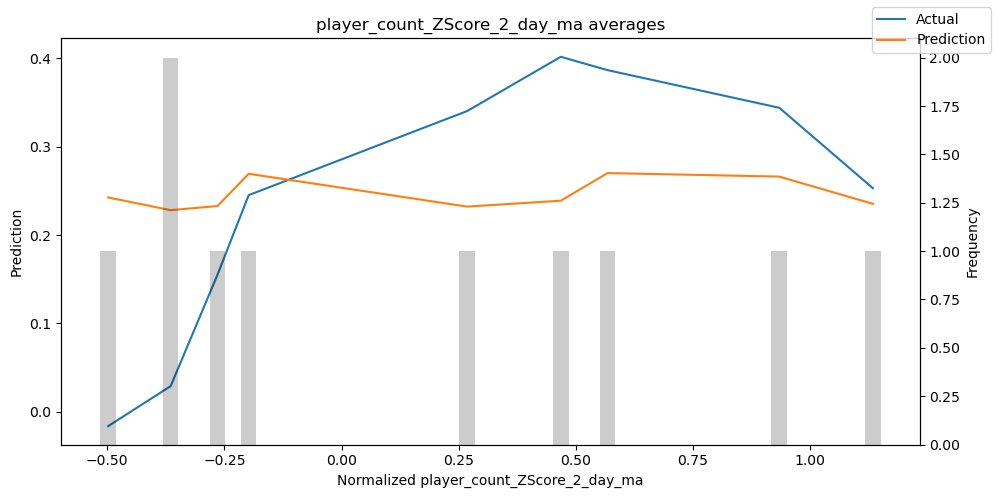

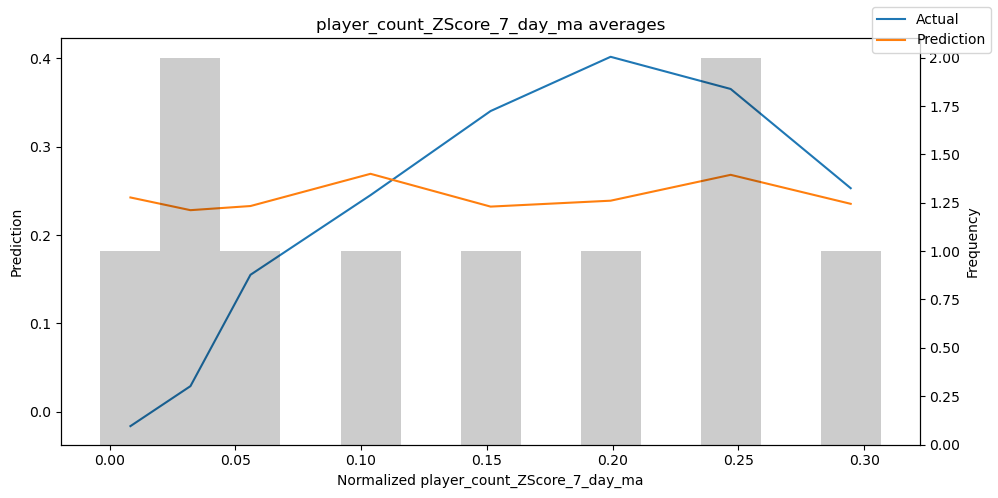

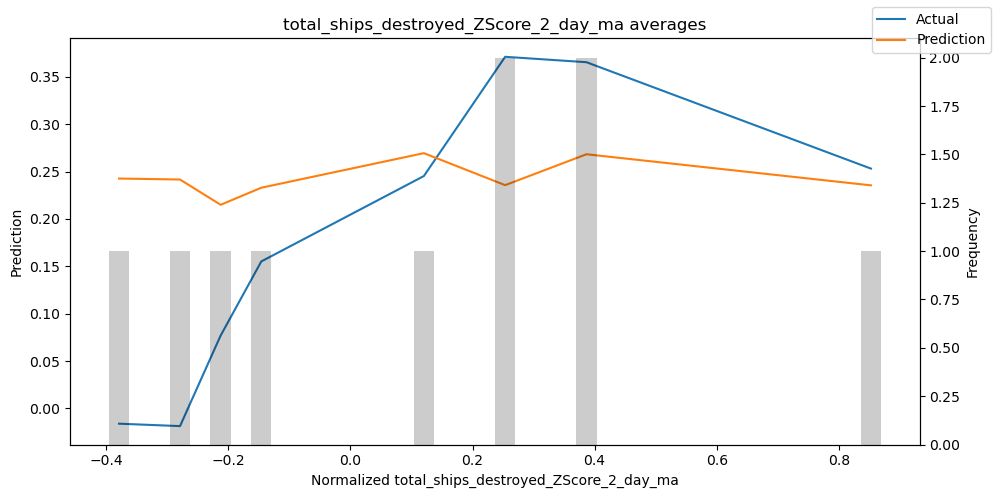

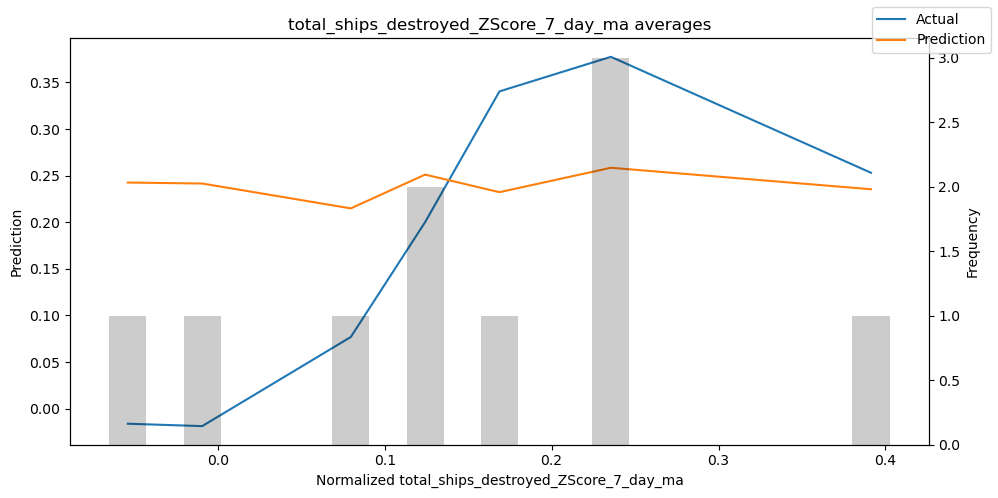

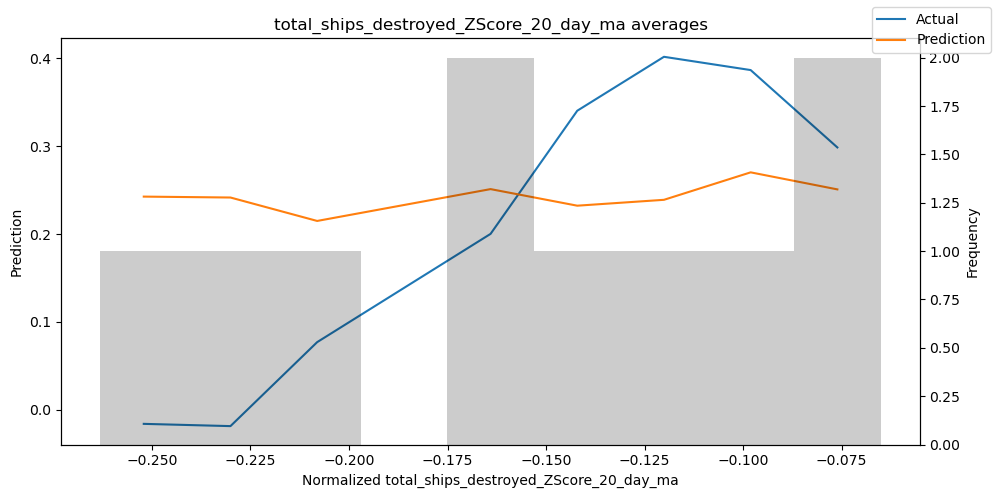

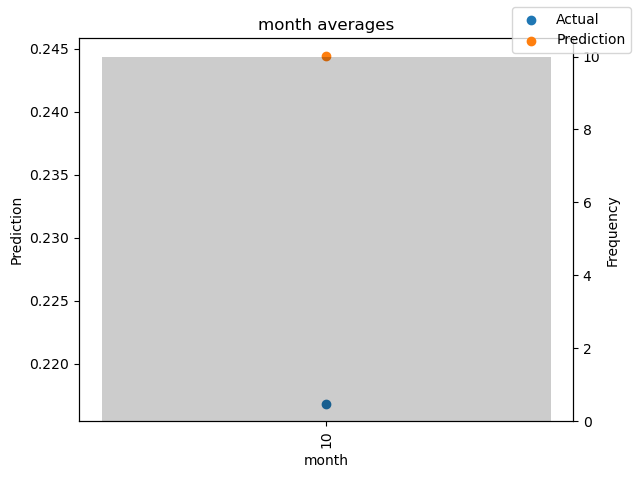

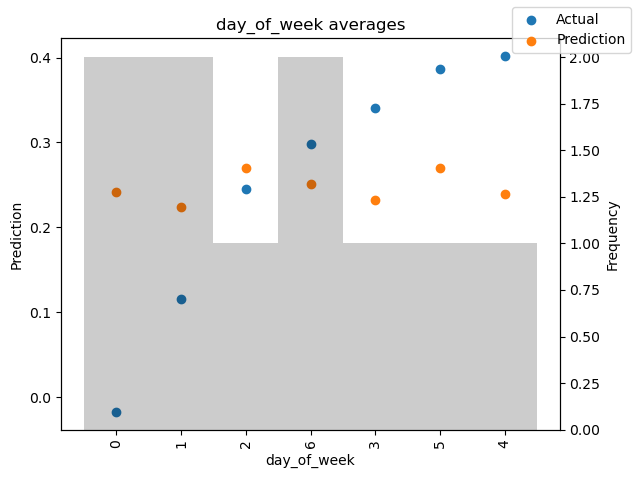

In [239]:
predictions = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

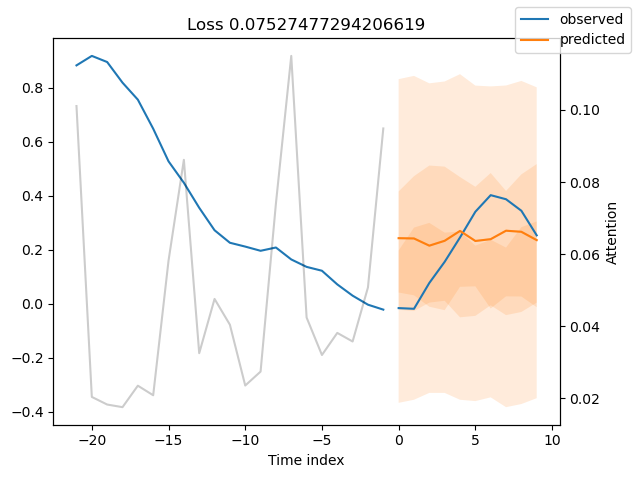

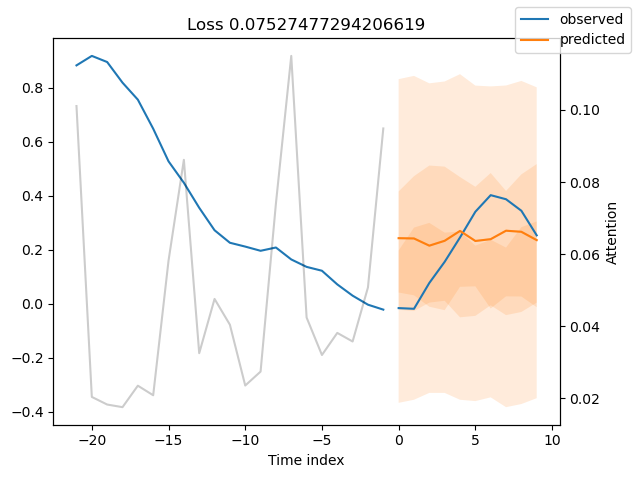

In [242]:
best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=0, add_loss_to_title=True)